### **Step-by-Step Tutorial for Implementing the Evidence Model in PyTorch Using Jupyter Notebook**

In [16]:

'''
Below is a Jupyter Notebook that walks you through implementing the `EvidenceModel` and a neural network in PyTorch. It starts by importing necessary libraries, creating the neural network, and continues with the creation of the evidence model and plotting functions.

First, let's start by importing the libraries we need:
'''

import torch
import torch.nn as nn
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import itertools
import torch.optim as optim

#### **Step 1: Implement the Simple Neural Network (SimpleNN)**

In [17]:
'''
Here, we define a simple neural network with two fully connected layers (`fc1` and `fc2`) and an output layer. We also add a Dropout layer to prevent overfitting.
'''
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 20)  # Input layer to the first hidden layer
        self.fc2 = nn.Linear(20, 10)  # First hidden layer to the second hidden layer
        self.output = nn.Linear(10, 3, bias=False)  # Output layer for three classes
        self.dropout = nn.Dropout(0.5)  # Dropout rate of 0.5 to prevent overfitting
        self.softmax = nn.Softmax(dim=1)  # Softmax activation for multi-class classification

    def forward(self, x, return_hidden=False):
        x = torch.relu(self.fc1(x))  # First layer output
        x = self.dropout(x)  # Dropout layer applied after the first layer
        hidden_output = torch.relu(self.fc2(x))  # Second layer output
        output = self.output(hidden_output)  # Output layer (linear)
        output = self.softmax(output)  # Softmax activation for final output
        if return_hidden:
            return hidden_output  # If needed, return hidden output as well
        return output

# Create an instance of the neural network model
clf = SimpleNN()

### **Step 2: Load Dataset and Model Parameters**

In [18]:

'''
In this step, you will load the dataset and saved model parameters. Make sure that your dataset (`dataset.pkl`) and model weights (`clf.pth`) are available in the working directory.
'''

# Load dataset (X and y)
with open('/data/huangtao/projects/uncertainty/euq/measures/dataset.pkl', 'rb') as f:
    X, y = pickle.load(f)

# Load model weights
clf.load_state_dict(torch.load('/data/huangtao/projects/uncertainty/euq/measures/clf.pth'))
model_weights = clf.output.weight.T  # Transpose of output layer weights



### **Step 3: Implement the EvidenceModel Class**

In [19]:

'''
Now, we implement the `EvidenceModel` class. This class handles the calculations of evidence weights, conflict, ignorance, and non-specificity measures. 
The class constructor takes a neural network output weight matrix as the parameter.
'''
class EvidenceModel:
    def __init__(self, Beta):
        self.B = Beta
        self.evidence_weights = None
        self.w_pos = None
        self.w_neg = None
        self.eta_pos_temp = None
        self.eta_neg_temp = None
        self.K = None

    def get_evidence_weights(self, Phi):
        J, K = self.B.shape
        with torch.no_grad():
            B = self.B.to(torch.float32)
            Phi = Phi.to(torch.float32)
            M = Phi.unsqueeze(0)
            B_star = B - B.mean(axis=1, keepdims=True)
            W = ((torch.mm(M, B_star)) / B.shape[0]).expand(J, K)
        self.evidence_weights = W.unsqueeze(0).to(dtype=torch.float64)
        self._calculate_basic_terms()
        return self.evidence_weights

    def _calculate_basic_terms(self):
        omega_jk_positive = torch.relu(self.evidence_weights)
        omega_jk_negative = torch.relu(-self.evidence_weights)
        self.w_pos1 = omega_jk_positive.sum(1)[0].unsqueeze(0)
        self.w_neg1 = omega_jk_negative.sum(1)[0].unsqueeze(0)
        self.K = self.w_pos1.shape[-1]
        self.eta_pos_temp = 1 / (torch.exp(self.w_pos1).sum(dim=1) - self.K + 1)
        self.eta_neg_temp = 1 / (1 - torch.prod(1 - torch.exp(-self.w_neg1), dim=1))

        # Handle zeros in w_pos
        sorted_w_pos = torch.sort(self.w_pos1.flatten())[0]
        second_smallest = sorted_w_pos[torch.nonzero(sorted_w_pos > 0, as_tuple=True)[0][0]]
        w_pos1_copy = self.w_pos1.clone()  # 创建 w_pos1 的副本
        w_pos1_copy[w_pos1_copy == 0] = second_smallest  # 修改副本中的值
        self.w_pos2 = w_pos1_copy  # 将修改后的副本赋值给 w_pos2
        # Handle zeros in w_neg
        sorted_w_neg = torch.sort(self.w_neg1.flatten())[0]
        second_smallest = sorted_w_neg[torch.nonzero(sorted_w_neg > 0, as_tuple=True)[0][0]]
        w_neg1_copy = self.w_neg1.clone()  # 创建 w_neg1 的副本
        w_neg1_copy[w_neg1_copy == 0] = second_smallest  # 修改副本中的值
        self.w_neg2 = w_neg1_copy  # 将修改后的副本赋值给 w_neg2
        # Calculate kappa
        self.kappa = torch.sum(self.eta_pos_temp.reshape(-1, 1) * (torch.exp(self.w_pos2) - 1) * (1 - self.eta_neg_temp.reshape(-1, 1) * torch.exp(-self.w_neg1)), dim=1)
        self.eta_temp = 1 / (1 - self.kappa)

    def get_evidence_conflict(self):
        return self.kappa

    def get_evidence_ignorance(self):
        # Calculate ignorance value using precomputed terms
        exp_results = torch.exp(-torch.sum(self.w_neg2, dim=1))
        w_neg_sum = exp_results.sum()
        ig = self.eta_temp * self.eta_pos_temp * self.eta_neg_temp * w_neg_sum
        return ig

    def get_nonspecific(self):
        # Calculate non-specificity value using precomputed terms
        eta_mul = self.eta_temp * self.eta_pos_temp * self.eta_neg_temp
        prod_term = torch.prod(1 - torch.exp(-self.w_neg2), dim=1, keepdim=True) / (1 - torch.exp(-self.w_neg2))
        second_term = (torch.exp(self.w_pos1) - 1) + prod_term
        first_term = eta_mul.reshape(-1, 1) * torch.exp(-self.w_neg2)
        m_theta = first_term * second_term
        return 1 - m_theta.sum()

    def compute_m(self, labels):
        w_neg = self.w_neg1.squeeze()
        w_pos = self.w_pos1.squeeze()
        mass_function = dict()
        subsets = self.generate_subsets(labels)
        for theta_set in subsets:
            if len(theta_set) == 0:
                m_value = 0
            elif len(theta_set) == 1:
                k = theta_set[0]
                m_value = torch.exp(-w_neg[k]) * (torch.exp(w_pos[k]) - 1 + torch.prod(torch.tensor([1 - torch.exp(-w_neg[l]) for l in range(len(w_neg)) if l != k])))
            elif len(theta_set) > 1:
                prod_not_in_A = np.prod([1 - np.exp(-w_neg[k]) for k in range(len(w_neg)) if k not in theta_set])
                prod_in_A = np.prod([np.exp(-w_neg[k]) for k in theta_set])
                m_value = prod_not_in_A * prod_in_A
            mass_function[theta_set] = m_value
        values = list(mass_function.values())
        total = sum(values)
        mass_function = {key: value / total for key, value in mass_function.items()}
        return mass_function

    def generate_subsets(self, input_set):
        subsets = []
        for r in range(len(input_set) + 1):
            subsets.extend(itertools.combinations(input_set, r))
        return [tuple(subset) for subset in subsets]

    def pl_A(self, labels, m_values):
        subsets = self.generate_subsets(labels)
        pl = dict()
        for A in subsets:
            pl_value = 0
            for B, m_B in m_values.items():
                if set(B).intersection(A):
                    pl_value += m_B
            pl[A] = pl_value
        return pl




### **Step 4: Plotting the Decision Boundaries**

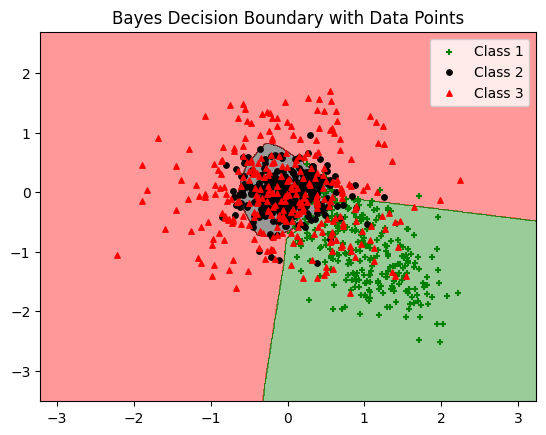

In [20]:

'''
We create a function to visualize the decision boundary of the trained neural network. This will give us insights into how well our model has been trained on the data.
'''
def predict(model, X):
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32)  # 转换输入为 tensor
        output = model(X_tensor)  # 前向传播计算
        _, predicted = torch.max(output, 1)  # 获取类别标签
    return predicted,output  # 转换为 numpy 数组
def plot_decision_boundary(clf, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict the result on the entire grid
    Z, _ = predict(clf, np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=ListedColormap(('black', 'red', 'green')))
    plt.scatter(X[y == 2][:, 0], X[y == 2][:, 1], c='green', marker='+', label='Class 1', s=15, facecolors='none')
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='black', marker='o', label='Class 2', s=15, facecolors='none')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='red', marker='^', label='Class 3', s=15, facecolors='none')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.legend(loc='best')
    plt.title('Bayes Decision Boundary with Data Points')
    plt.show()

plot_decision_boundary(clf, X, y)



### **Step 5: Computing Evidence Measures**

In [21]:

'''
In the final step, we compute various measures using the `EvidenceModel` class, including `conflict`, `ignorance`, and `non-specificity`.
'''
def get_hidden_layer_output(model,X):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32)
        hidden_output = model(X_tensor, return_hidden=True)
    return hidden_output
# Create an instance of EvidenceModel with the model weights
evidence_model = EvidenceModel(model_weights)

# Compute evidence measures for each data point
for i, x in enumerate(X):
    phi = torch.tensor(get_hidden_layer_output(clf, X))[i]
    evidence_weights = evidence_model.get_evidence_weights(phi)
    conflict_value = evidence_model.get_evidence_conflict()
    nonspecific_value = evidence_model.get_nonspecific()
    ig_value = evidence_model.get_evidence_ignorance()
    print(f"Data Point {i}: Conflict: {conflict_value}, Non-Specificity: {nonspecific_value}, Ignorance: {ig_value}")

/tmp/ipykernel_302187/368497476.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi = torch.tensor(get_hidden_layer_output(clf, X))[i]


Data Point 0: Conflict: tensor([0.2801], dtype=torch.float64), Non-Specificity: 0.9991324331686993, Ignorance: tensor([3.5828e-12], dtype=torch.float64)
Data Point 1: Conflict: tensor([0.0013], dtype=torch.float64), Non-Specificity: 0.9950339988560241, Ignorance: tensor([7.0344e-10], dtype=torch.float64)
Data Point 2: Conflict: tensor([0.0003], dtype=torch.float64), Non-Specificity: 0.9951254905284013, Ignorance: tensor([5.6957e-10], dtype=torch.float64)
Data Point 3: Conflict: tensor([1.2216], dtype=torch.float64), Non-Specificity: 4.425493043781961, Ignorance: tensor([-0.0002], dtype=torch.float64)
Data Point 4: Conflict: tensor([0.0036], dtype=torch.float64), Non-Specificity: 0.9944994820958493, Ignorance: tensor([1.2413e-09], dtype=torch.float64)
Data Point 5: Conflict: tensor([0.0078], dtype=torch.float64), Non-Specificity: 0.9987511352646048, Ignorance: tensor([7.0553e-12], dtype=torch.float64)
Data Point 6: Conflict: tensor([1.2199], dtype=torch.float64), Non-Specificity: 4.4619

/tmp/ipykernel_302187/368497476.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_302187/2982070153.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi = torch.tensor(get_hidden_layer_output(clf, torch.tensor([w_neg, w_pos]).reshape(1, 2)))[0]


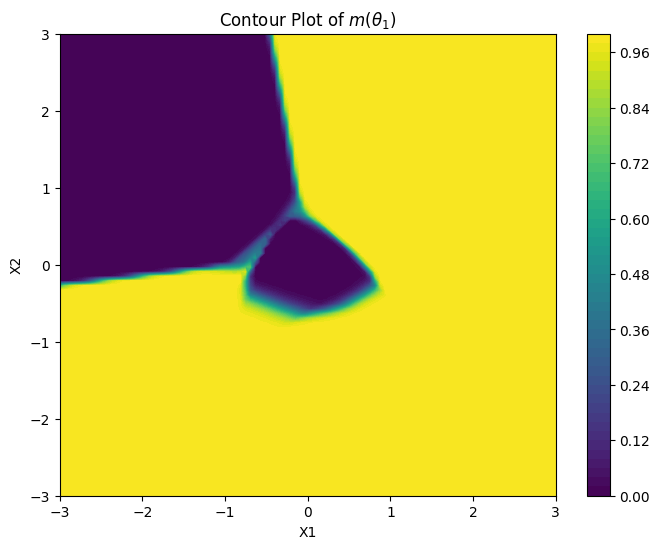

In [22]:
def plot_m1(clf, evidence_model):
    # Generate grid of w_neg and w_pos values for contour plotting
    w_neg_values = np.linspace(-3, 3, 100)
    w_pos_values = np.linspace(-3, 3, 100)
    labels = [0, 1, 2]  # Example label set

    # Compute m values for (1,) subset
    m_values = np.zeros((len(w_neg_values), len(w_pos_values)))
    
    for i, w_neg in enumerate(w_neg_values):
        for j, w_pos in enumerate(w_pos_values):
            phi = torch.tensor(get_hidden_layer_output(clf, torch.tensor([w_neg, w_pos]).reshape(1, 2)))[0]
            evidence_model.get_evidence_weights(phi)
            mass_function = evidence_model.compute_m(labels)
            if (1,) in mass_function:
                # print(f"w_neg: {w_neg}, w_pos: {w_pos}, m_value: {mass_function[(0,)]}")
                m_values[i, j] = mass_function[(1,)]

    # Plot the contour plot
    plt.figure(figsize=(8, 6))
    plt.contourf(w_pos_values,w_neg_values, m_values, levels=50, cmap='viridis')
    plt.colorbar()
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(r'Contour Plot of $m(\theta_{1})$')
    # plt.savefig("m1_contour.png")
    plt.show()
plot_m1(clf,evidence_model)


### **Conclusion**

In this Jupyter Notebook, we implemented a neural network model and an `EvidenceModel` to compute evidence-based measures for decision boundaries. We visualized the decision boundaries of the neural network and calculated metrics like conflict, non-specificity, and ignorance for each data point. This can be used in further analysis to understand how our neural network is making decisions and to diagnose potential areas for improvement.

If you need any more specific explanations for each part of the code or if you'd like me to add more comments, feel free to ask!